In [159]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
phoneme = fetch_openml(name='phoneme')
X = phoneme.data
y = np.vectorize(lambda x: int(x)-1)(phoneme.target)

## Method to do 10-fold CV for all classifiers

In [207]:
def cross_val(X, y, k_fold=10, classifiers_dict=None):
    """ 
    clf_dict: There is a hardcoded version of this dict to handle
                the classifiers mentioned in hw, but you can pass your own
    X: data, numpy array
    y: labels, numpy array
    k_fold: int, default 10
    """
    def get_idxs_():
        """
         helper function to return a dictionary of form:
            {'fold number': fold indices}
            fold number: integer
            fold indices: numpy array of random selection of indices 
                      of length equal to or nearly equal to X.shape[0]/k_fold
            fold indices are non-overlapping
        """
        idx = np.array(range(X.shape[0]))
        np.random.shuffle(idx) #Shuffle in case data comes in some ordered fashion
        folds_idx = np.array_split(idx, k_fold) # array_split handles equal splitting
        folds_dict = {}
        for i in range(k_fold):
            folds_dict[i] = folds_idx[i]
        return folds_dict
    
    
    if classifiers_dict is None:
        classifiers_dict = {'KNN': {'clf': KNeighborsClassifier,
                                    'params': None},
                            'SVM': {'clf': SVC,
                                    'params': None},
                            'Logistic Regression': {'clf': LogisticRegression,
                                                    'params': None},
                            'Gaussian Naive Bayes': {'clf': GaussianNB,
                                                     'params': None},
                            'Perceptron': {'clf': Perceptron,
                                           'params': None}}
    
    folds_idx = get_idxs_()
    results_dict = {}
    for name in classifiers_dict:
        print('Starting cv round for {}'.format(name))
        results_dict[name] = {}
        params = classifiers_dict[name]['params']
        for i in range(10):
            if params is not None:
                clf = classifiers_dict[name]['clf'](**params)
            else:
                clf = classifiers_dict[name]['clf']()
            test_fold = i
            test_idx = folds_idx[test_fold]
            train_folds = list(range(10))
            train_folds.remove(i)
            train_idx = np.array([])
            for fold in train_folds:
                train_idx = np.append(train_idx, folds_idx[fold])
            test_idx = test_idx.astype('int')
            train_idx = train_idx.astype('int')
            clf.fit(X[train_idx], y[train_idx])
            preds = clf.predict(X[test_idx])
            score = roc_auc_score(y[test_idx], preds)
            results_dict[name][test_fold] = score

    return results_dict

In [197]:
results = cross_val(X, y)

Starting cv round for KNN
Starting cv round for SVM
Starting cv round for Logistic Regression
Starting cv round for Gaussian Naive Bayes
Starting cv round for Perceptron


In [198]:
results_df = pd.DataFrame.from_dict(results)

## Results dataframe containing the roc_auc scores for each round

In [199]:
results_df

KNN       SVM  Logistic Regression  Gaussian Naive Bayes  Perceptron
0  0.868827  0.849553             0.661442              0.756222    0.664549
1  0.830337  0.797741             0.645999              0.735078    0.612296
2  0.820546  0.791424             0.646881              0.742375    0.651673
3  0.847535  0.771401             0.656313              0.721648    0.635092
4  0.839746  0.812480             0.698728              0.756836    0.500000
5  0.822413  0.790658             0.644784              0.767155    0.693046
6  0.837302  0.804674             0.661817              0.728395    0.659612
7  0.897326  0.848449             0.628902              0.765110    0.725595
8  0.865838  0.846947             0.699312              0.772188    0.416996
9  0.833051  0.826879             0.708017              0.767736    0.642295

## Plot with apriori knowledge of the correct ordering

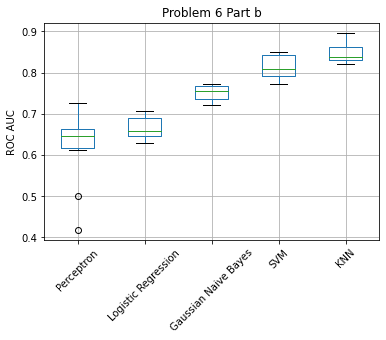

In [200]:
ax = results_df[['Perceptron', 'Logistic Regression',
            'Gaussian Naive Bayes', 'SVM', 'KNN']].boxplot(rot=45)
ax.set_title('Problem 6 Part b')
ax.set_ylabel('ROC AUC')
fig = ax.get_figure()
fig.savefig('hw4_p6_part_b_boxplot.png')

## For part d we cannot use sklearn gridsearchcv with the previous method

In [201]:
def sklearn_compatible_cv(X):
    """
    Return iterator that yields (train_indices, test_indices)
    """
    def get_idxs_(X):
        """
         helper function to return a dictionary of form:
            {'fold number': fold indices}
            fold number: integer
            fold indices: numpy array of random selection of indices 
                      of length equal to or nearly equal to X.shape[0]/k_fold
            fold indices are non-overlapping
        """
        idx = np.array(range(X.shape[0]))
        np.random.shuffle(idx) #Shuffle in case data comes in some ordered fashion
        folds_idx = np.array_split(idx, k_fold) # array_split handles equal splitting
        folds_dict = {}
        for i in range(k_fold):
            folds_dict[i] = folds_idx[i]
        return folds_dict

    folds_idx = get_idxs_(X)
    train_indices = []
    test_indices = []
    for i in range(10):
        test_fold = i
        test_idx = folds_idx[test_fold]
        train_folds = list(range(10))
        train_folds.remove(i)
        train_idx = np.array([])
        for fold in train_folds:
            train_idx = np.append(train_idx, folds_idx[fold])
        test_idx = test_idx.astype('int')
        train_idx = train_idx.astype('int')
        train_indices.append(train_idx)
        test_indices.append(test_idx)

    custom_cv = zip(train_indices, test_indices)
    return custom_cv

## Part d

SVM kernel tuning

In [185]:
custom_cv = sklearn_compatible_cv(X)
params = {'kernel':('poly', 'rbf'),
          'C': [0.1, 0.01, 0.5, 0.05]}
model = SVC()
clf = GridSearchCV(model, params,
                   cv=custom_cv,
                   scoring='roc_auc')
clf.fit(X, y)
svm_params = clf.best_params_

In [169]:
custom_cv = sklearn_compatible_cv(X)
params = {'n_neighbors':(1,2,3,4,5)}
model = KNeighborsClassifier()
clf = GridSearchCV(model, params,
                   cv=custom_cv,
                   scoring='roc_auc')
clf.fit(X, y)
knn_params = clf.best_params_

In [170]:
custom_cv = sklearn_compatible_cv(X)
params = {'var_smoothing':(10**-9, 10**-8, 10**-7, 10**-6, 10**-5)}
model = GaussianNB()
clf = GridSearchCV(model, params,
                   cv=custom_cv,
                   scoring='roc_auc')
clf.fit(X, y)
gnb_params = clf.best_params_

In [203]:
clf_dict = {'KNN': {'clf': KNeighborsClassifier,
                            'params': knn_params},
                    'SVM': {'clf': SVC,
                            'params': svm_params},
                    'Gaussian Naive Bayes': {'clf': GaussianNB,
                                             'params': gnb_params}}

In [208]:
results_dict = cross_val(X, y, k_fold=10, classifiers_dict=clf_dict)

Starting cv round for KNN
Starting cv round for SVM
Starting cv round for Gaussian Naive Bayes


In [211]:
results_df = pd.DataFrame.from_dict(results_dict)

In [212]:
results_df

KNN       SVM  Gaussian Naive Bayes
0  0.827569  0.793271              0.764509
1  0.842916  0.787570              0.749250
2  0.853542  0.843221              0.765197
3  0.835176  0.771829              0.717023
4  0.845972  0.784672              0.736799
5  0.853618  0.776645              0.756414
6  0.864307  0.802178              0.759908
7  0.856588  0.824154              0.736054
8  0.829594  0.805725              0.760561
9  0.842836  0.828570              0.757141

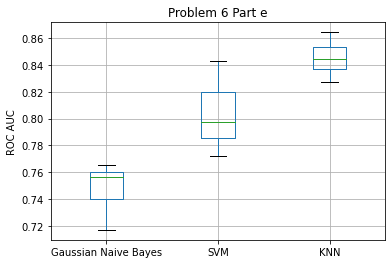

In [215]:
ax = results_df[['Gaussian Naive Bayes', 'SVM', 'KNN']].boxplot()
ax.set_title('Problem 6 Part e')
ax.set_ylabel('ROC AUC')
fig = ax.get_figure()
fig.savefig('hw4_p6_part_e_boxplot.png')